# Dependencies and files

## Install dependencies

## Imports

In [2]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [3]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [4]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [5]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [6]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

sum_sq    df         F    PR(>F)  p_val_adj
A1BG   0.122578  12.0  2.796490  0.003701   0.010364
AAAS   0.017527  12.0  0.944161  0.509517   0.596369
AACS   0.136394  12.0  2.729393  0.004508   0.012212
AADAT  0.057031  12.0  5.478881  0.000002   0.000016
AAGAB  0.043359  12.0  2.127609  0.026045   0.053640

In [7]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [8]:
pb_dir_path = '../../data/pseudobulks/'

In [9]:
os.listdir(pb_dir_path)

['4spe_pb_mean_filt.h5ad',
 '4spe_pb_mean_filt_nor_mean.h5ad',
 'pb_age.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [10]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [11]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

9208

## Specie-specific genes

In [12]:
import pickle
with open("./results/specie_specific_genes_tr50.pkl", "rb") as file:
    genes_dict77 = pickle.load(file)

## Helpful functions

In [13]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [14]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [15]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# Clusterisation

In [16]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [17]:
hs_genes = genes_dict77['human']

In [18]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_hs = df[hs_genes]

## Hierarchial

D:\Projects\spatialMPFC\venv\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


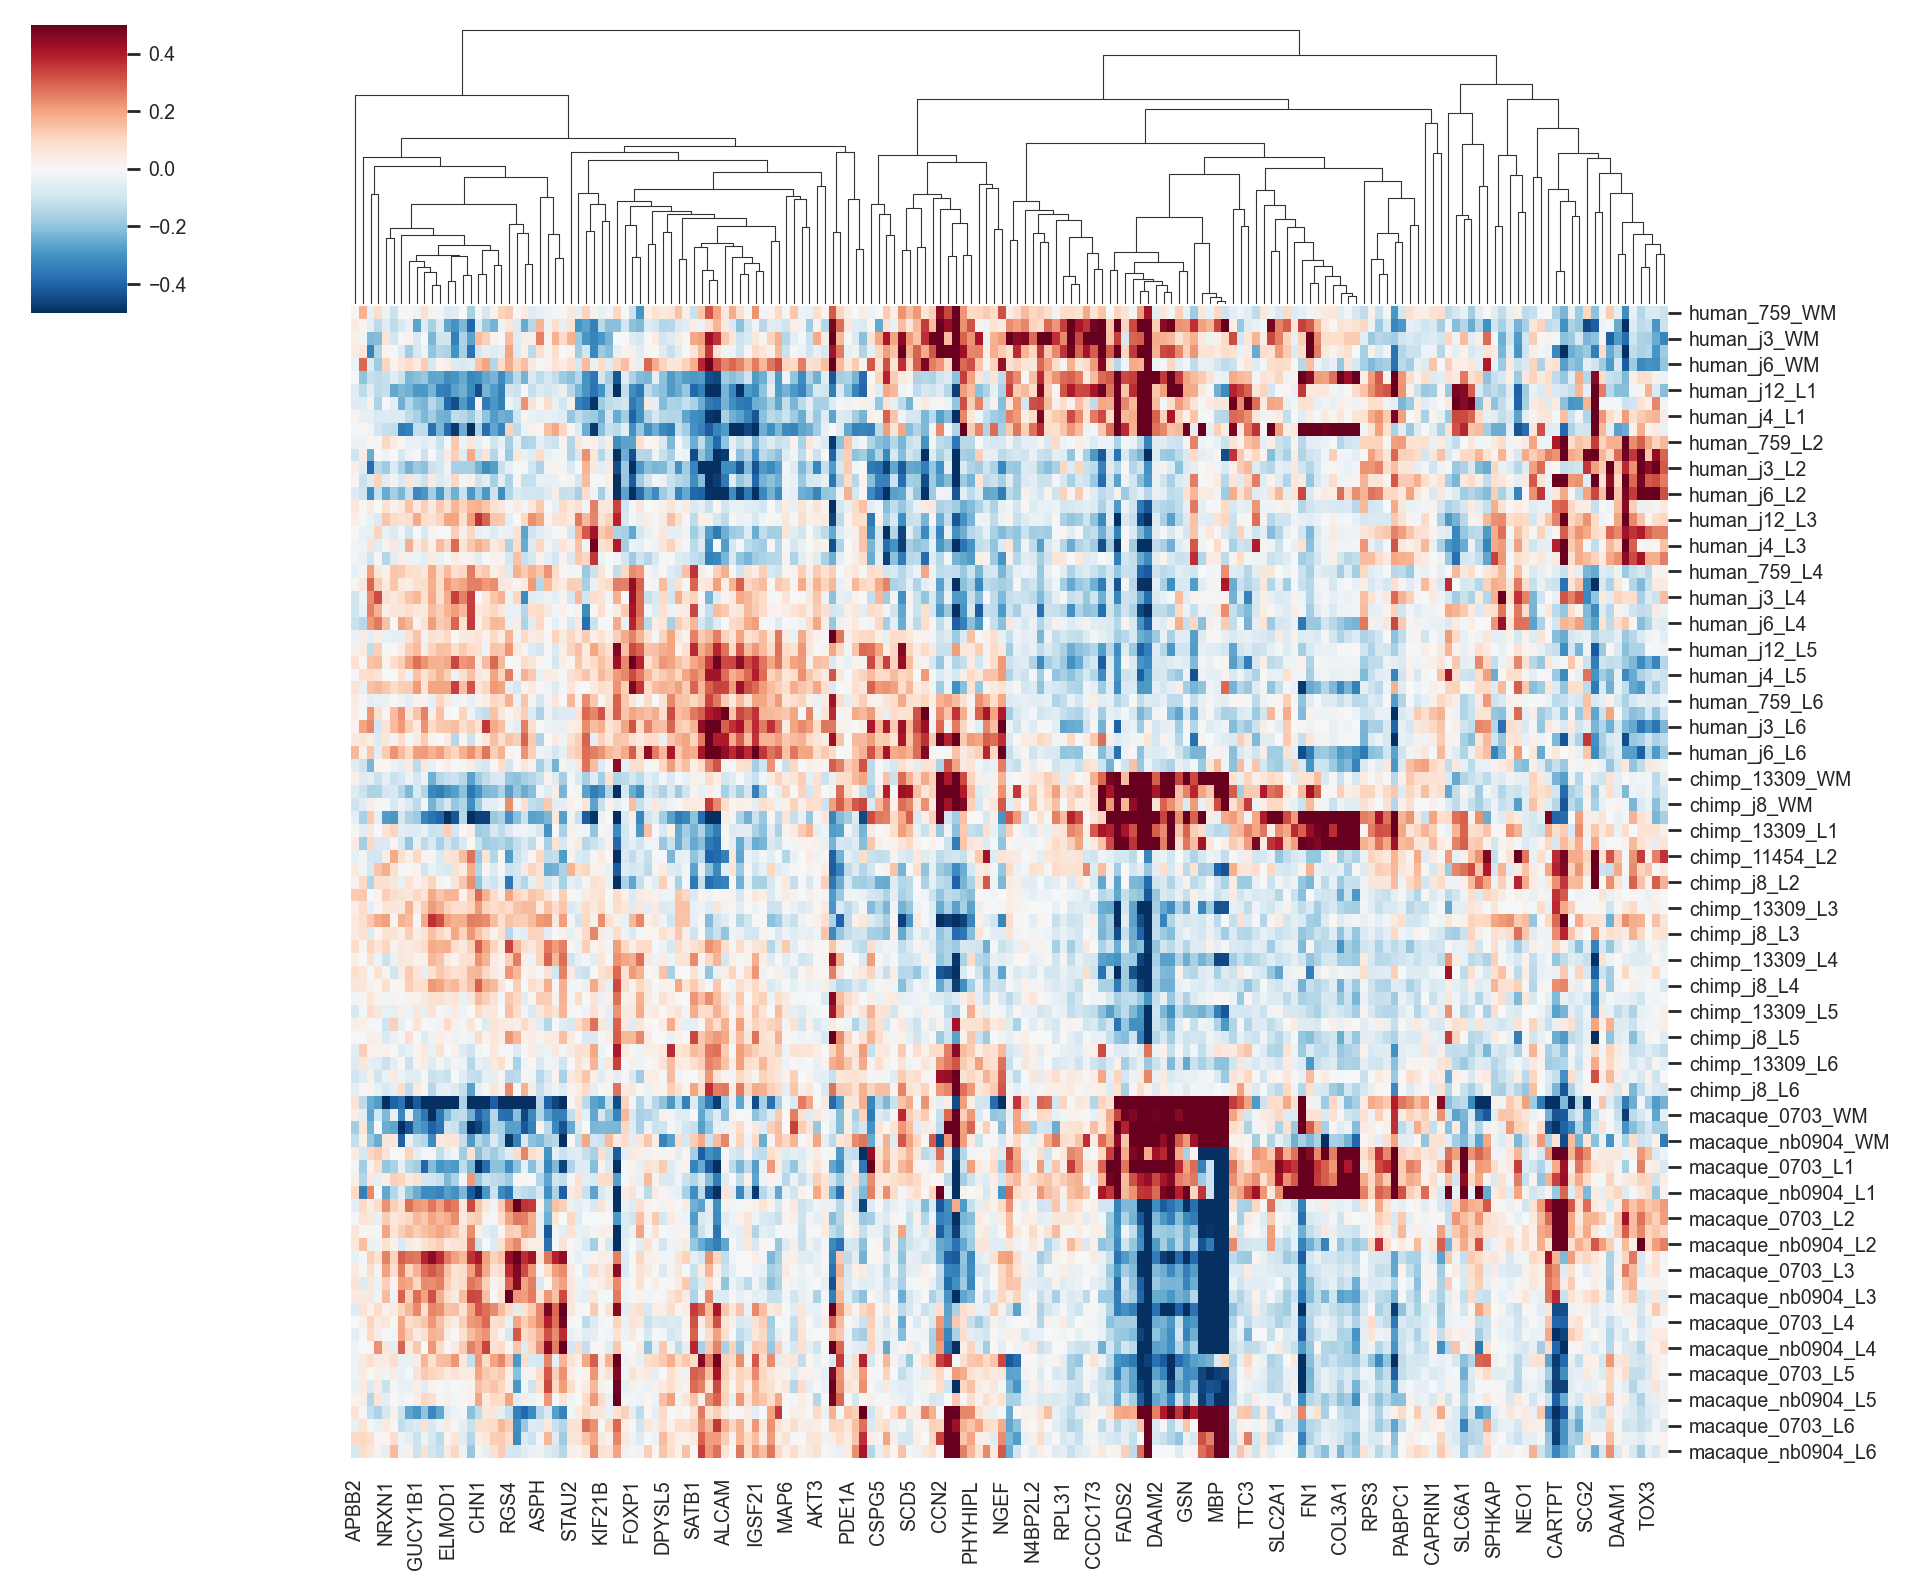

In [19]:
sns.set(font_scale=0.8)
sns.clustermap(df_hs, figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.5, vmin=-0.5, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

## Spectral clusterisation

In [48]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
aff_matrix = pairwise_kernels(df_hs.loc[sample_order['human']].T, metric='cosine') + 1
n_clusters = 4
clustering = SpectralClustering(n_clusters=n_clusters, gamma=1, affinity='precomputed', random_state=4)
clustering.fit(aff_matrix)

SpectralClustering(affinity='precomputed', gamma=1, n_clusters=4,
                   random_state=4)

In [49]:
labels = pd.Series(clustering.labels_, index=hs_genes).sort_values()
order = labels.sort_values().index

In [50]:
labels.to_csv('./results/human_clusters_50.csv')

In [51]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [52]:
colors = cluster_color[:n_clusters]
clusters = np.arange(n_clusters)

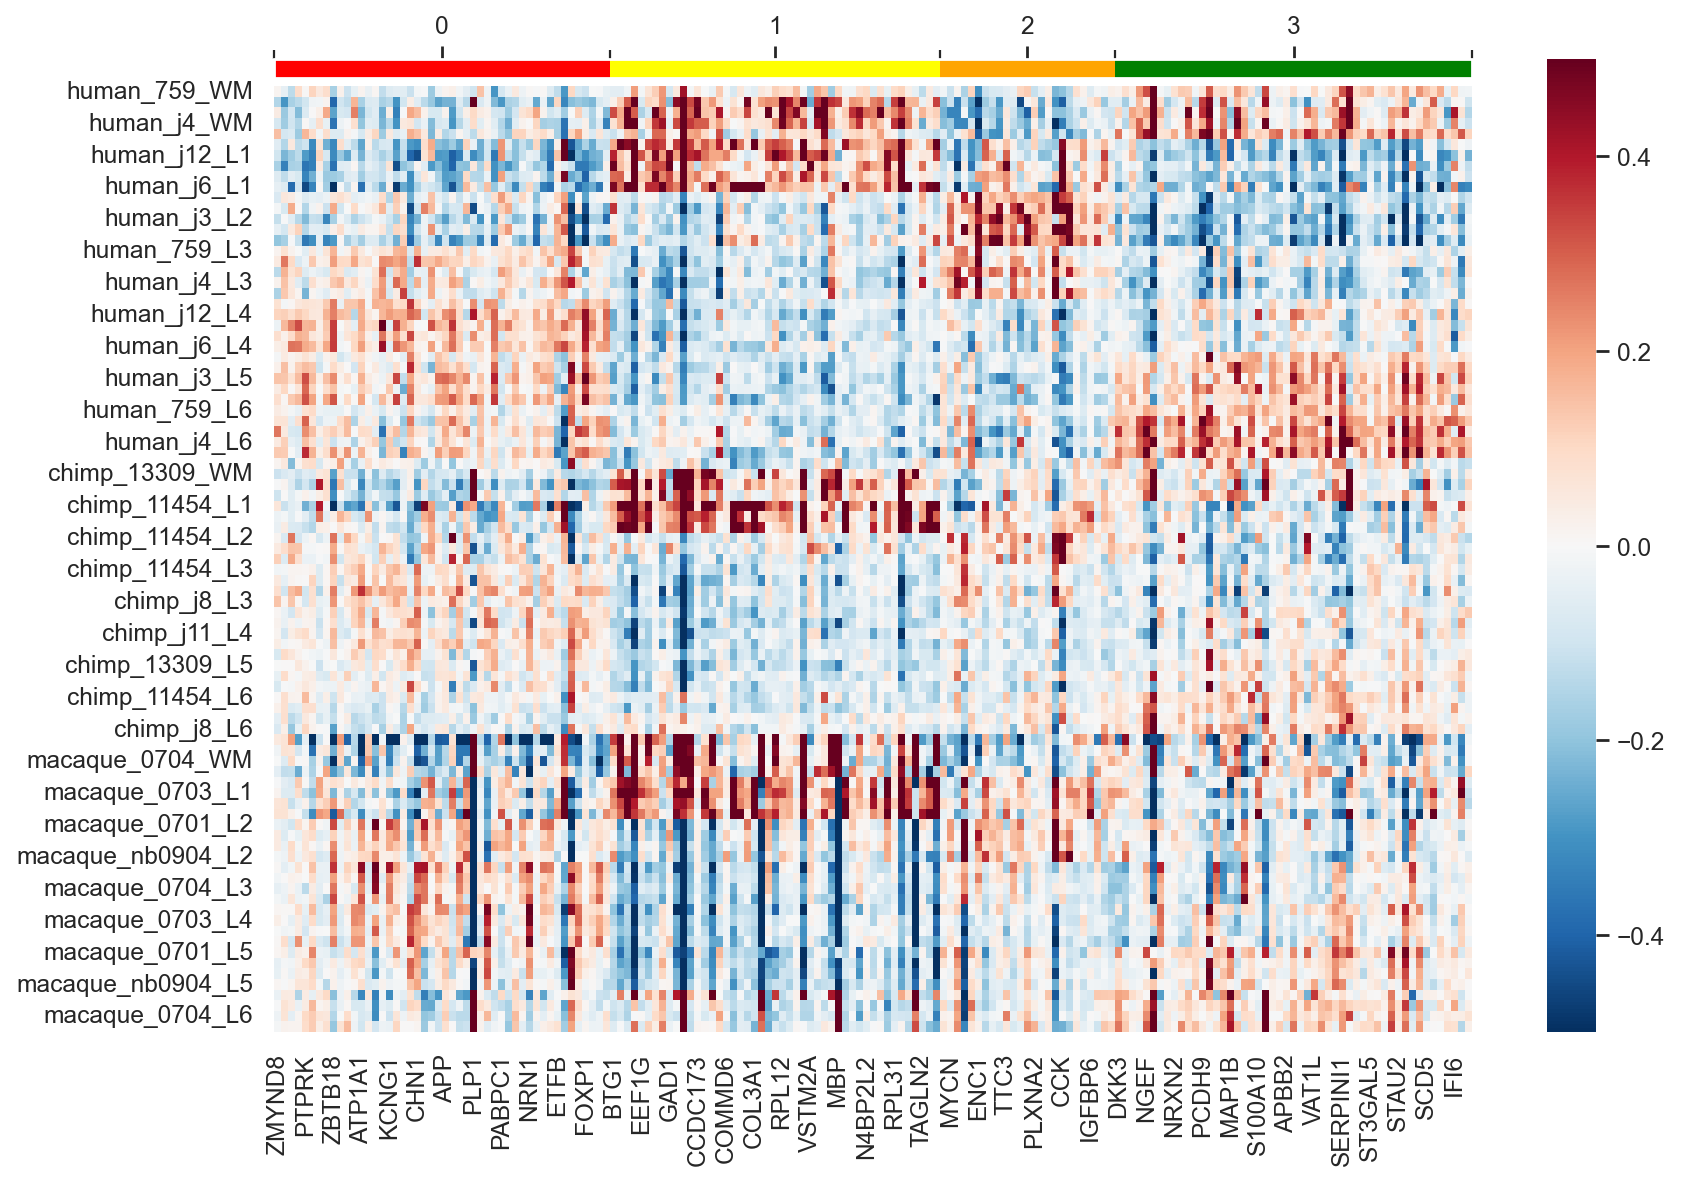

In [53]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_hs[order], ax=ax, cmap="RdBu_r", vmax=0.5, vmin=-0.5, center=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = mpl.colors.ListedColormap(colors)

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

In [55]:
labels[labels == 1].size

47

## Cluster profiles

In [56]:
df_annotation = df_hs.copy()
df_annotation['layer'] = adata_pb_norm.obs.layer
df_annotation['condition'] = adata_pb_norm.obs.condition

In [57]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

ACTA2      ADI1      AKT3     ALCAM      ANK2     APBB2  \
condition layer                                                               
chimp     L1     0.728220  0.232106 -0.012988  0.009130 -0.074303  0.000521   
          L2    -0.127487 -0.029761 -0.013202 -0.242804 -0.107423  0.009758   
          L3    -0.095616 -0.081698  0.004795 -0.066325 -0.046509  0.064595   
          L4    -0.111591 -0.069586 -0.005160  0.006249 -0.037624  0.065062   
          L5    -0.077636 -0.055009 -0.032334  0.134409 -0.015614 -0.020785   

                   APCDD1     APLP2       APP      AQP4  ...      TSPO  \
condition layer                                          ...             
chimp     L1     0.438053 -0.006447 -0.143722  0.764710  ...  0.040045   
          L2    -0.015450 -0.034986 -0.104327 -0.096835  ... -0.052895   
          L3    -0.180579 -0.042810  0.091190 -0.409157  ... -0.039607   
          L4    -0.162720 -0.058964  0.091682 -0.409665  ... -0.063044   
          L5    -0.139614  0.015875  0.062882 -0.282063  ... -0.015141   

                     TTC3     TTYH1    TUBA4A     UBAP2     VAT1L    VSTM2A  \
condition layer                                                               
chimp     L1     0.146501  0.071092 -0.190006  0.001697 -0.134595  0.077321   
          L2    -0.025527  0.014022 -0.271730  0.053347 -0.027984  0.210841   
          L3    -0.097487  0.005924 -0.212395 -0.041216 -0.090556  0.094489   
          L4    -0.118147 -0.032925  0.030377  0.017843 -0.019777  0.014245   
          L5    -0.079551 -0.050280  0.149852 -0.056467  0.138460 -0.087230   

                   ZBTB18      ZEB2    ZMYND8  
condition layer                                
chimp     L1    -0.154330  0.037896 -0.001521  
          L2     0.229193  0.051170  0.059591  
          L3     0.178206 -0.040480  0.063579  
          L4     0.129230 -0.075607  0.019230  
          L5     0.023022 -0.057856 -0.050828  

[5 rows x 171 columns]

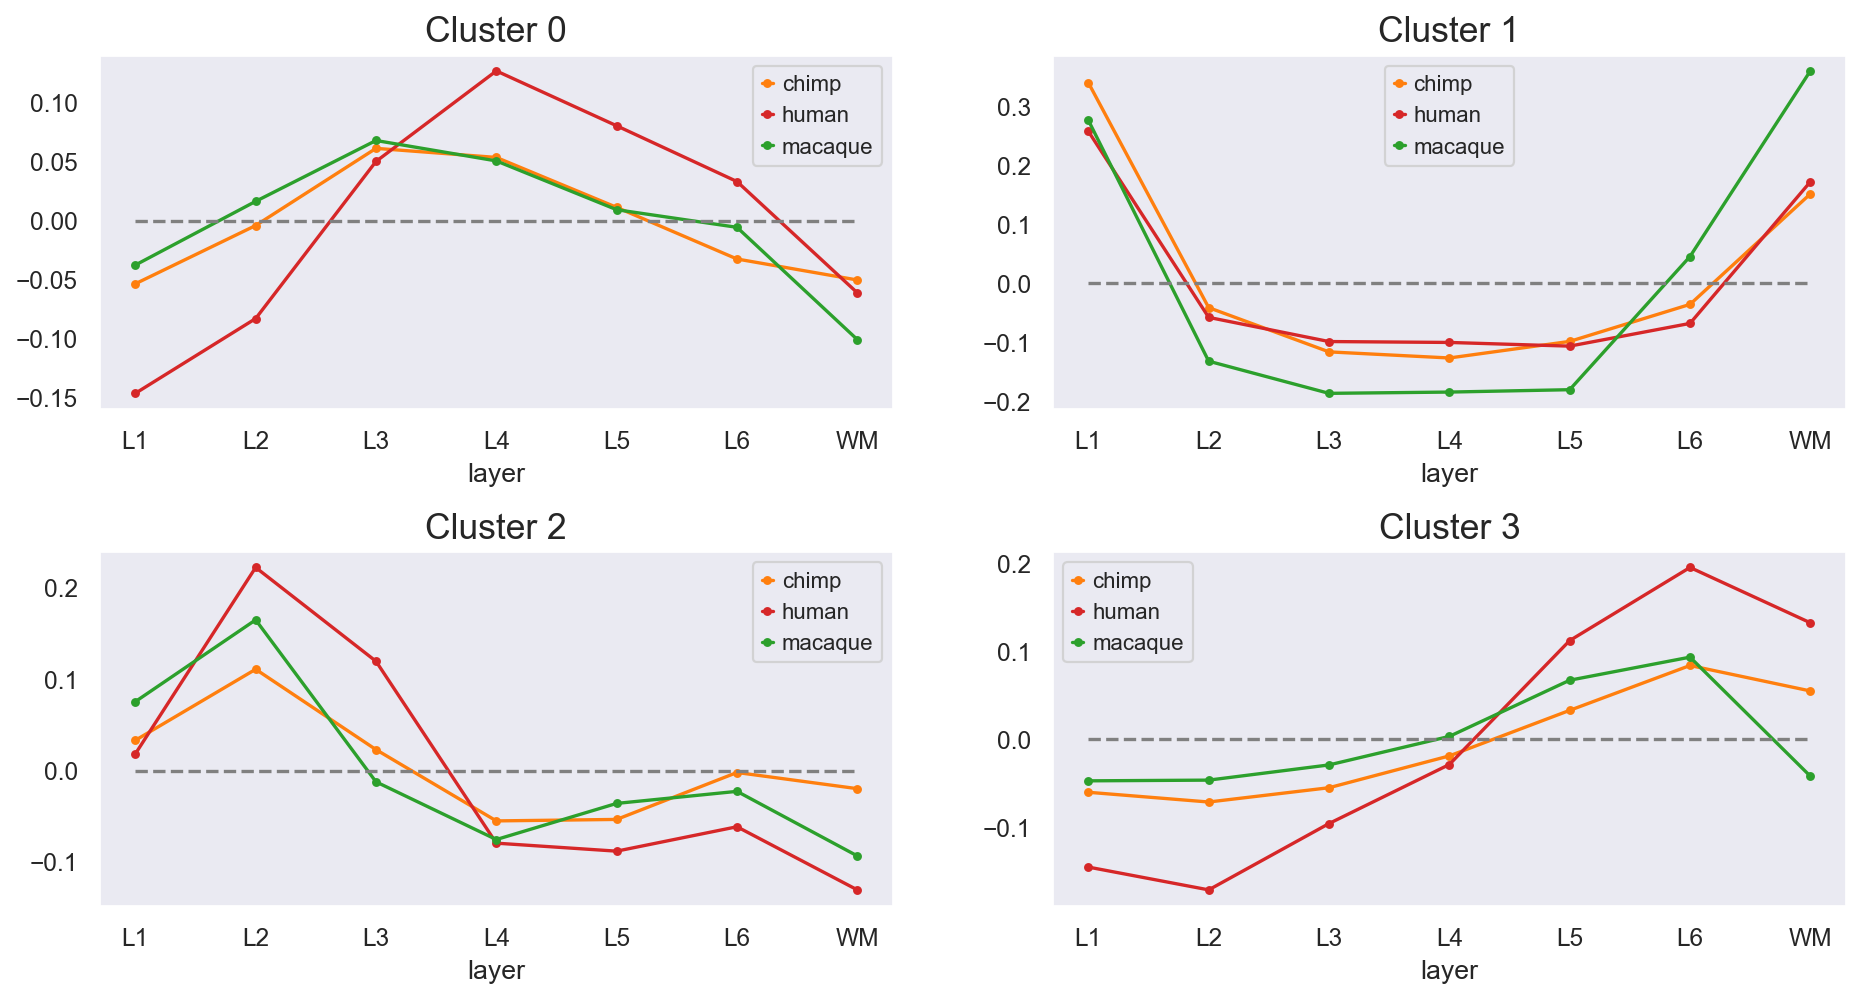

In [58]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

# Intersection with ANOVA clusters

In [59]:
anova_hs_inter = hs_genes.intersection(anova_labels.index)
anova_hs_inter

Index(['ACTA2', 'ADI1', 'AKT3', 'ALCAM', 'ANK2', 'APBB2', 'APCDD1', 'APLP2',
       'APP', 'AQP4',
       ...
       'TSPO', 'TTC3', 'TTYH1', 'TUBA4A', 'UBAP2', 'VAT1L', 'VSTM2A', 'ZBTB18',
       'ZEB2', 'ZMYND8'],
      dtype='object', length=159)

In [60]:
table_to_pivot = pd.concat([anova_labels.loc[anova_hs_inter], labels.loc[anova_hs_inter]], axis=1)
table_to_pivot.columns = ['ANOVA_labels', 'hs_labels']
pivot_labels_inter = table_to_pivot.groupby('ANOVA_labels').value_counts().unstack().fillna(0)
pivot_labels_inter

hs_labels        0     1     2     3
ANOVA_labels                        
0              7.0   1.0  16.0   0.0
1              1.0   1.0   3.0   9.0
2             18.0   0.0   1.0  27.0
3              1.0   7.0   0.0   0.0
4              0.0   6.0   0.0   2.0
5             15.0   3.0   1.0   5.0
6              2.0  23.0   3.0   7.0

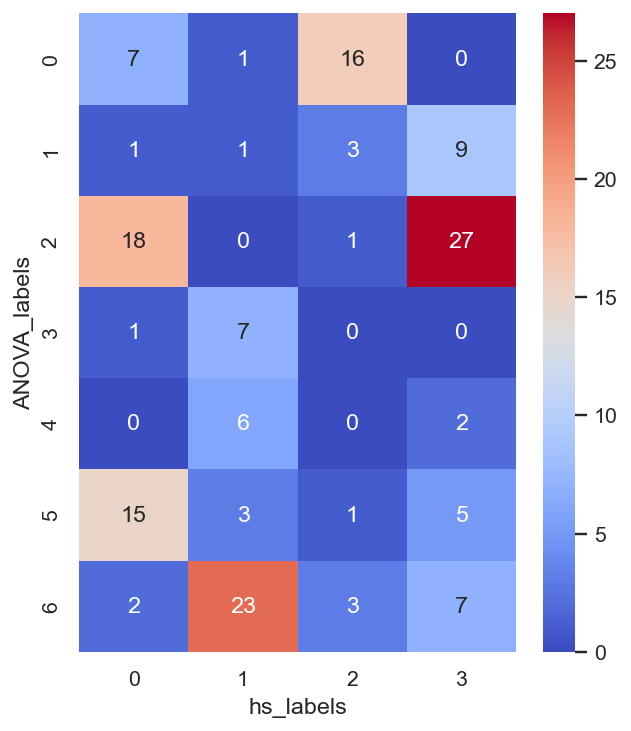

In [61]:
plt.figure(figsize=(5, 6), dpi=70)
sns.set(font_scale=1)
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f")
plt.grid(False)

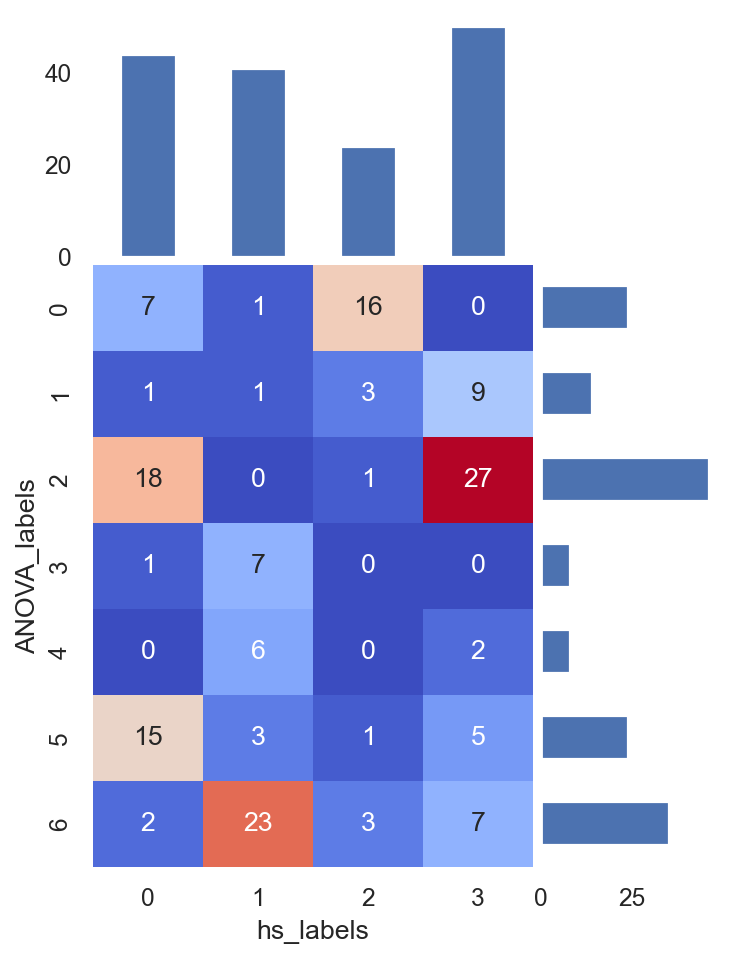

In [62]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 7))
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f", ax=ax, cbar=False)


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='40%', pad=0.05)
pivot_labels_inter.sum(axis=0).plot.bar(ax=cax)
cax.set_facecolor(color='white')
cax.get_xaxis().set_visible(False)

cax = divider.append_axes('right', size='40%', pad=0.05)
index_order = pivot_labels_inter.index[::-1]
pivot_labels_inter.sum(axis=1).loc[index_order].plot.barh(ax=cax)
cax.set_facecolor(color='white')
cax.get_yaxis().set_visible(False)

# Functional analysis

In [63]:
gene_clust = list()
enrich_results = list()

for label in tqdm(sorted(labels.unique())):
    genes = labels[labels == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of human-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/4 [00:00<?, ?it/s]

## GO_Biological_Process_2021

In [64]:
GeneCluster.enrich_geneclusters(gene_clust, 'GO_Biological_Process_2021')

In [65]:
enrich_res = pd.concat([gc.enrichment_res['GO_Biological_Process_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
regulation of chemokine production (GO:0032642)        1  0.000028   
regulation of interleukin-1 beta production (GO...     2  0.000191   
triglyceride catabolic process (GO:0019433)            3  0.000263   
regulation of chemokine (C-X-C motif) ligand 2 ...     4  0.000394   
axonal transport of mitochondrion (GO:0019896)         5  0.000936   

                                                       Z-score  \
Term                                                             
regulation of chemokine production (GO:0032642)      67.785185   
regulation of interleukin-1 beta production (GO...   32.073684   
triglyceride catabolic process (GO:0019433)         132.710145   
regulation of chemokine (C-X-C motif) ligand 2 ...   99.521739   
axonal transport of mitochondrion (GO:0019896)       56.850932   

                                                    Combined score  \
Term                                                                 
regulation of chemokine production (GO:0032642)         709.889259   
regulation of interleukin-1 beta production (GO...      274.658402   
triglyceride catabolic process (GO:0019433)            1093.750975   
regulation of chemokine (C-X-C motif) ligand 2 ...      780.202495   
axonal transport of mitochondrion (GO:0019896)          396.480493   

                                                    Overlapping genes  \
Term                                                                    
regulation of chemokine production (GO:0032642)     [APP, LPL, FOXP1]   
regulation of interleukin-1 beta production (GO...  [APP, LPL, FOXP1]   
triglyceride catabolic process (GO:0019433)              [FABP7, LPL]   
regulation of chemokine (C-X-C motif) ligand 2 ...       [LPL, FOXP1]   
axonal transport of mitochondrion (GO:0019896)           [NEFL, SYBU]   

                                                    Adjusted P-value  \
Term                                                                   
regulation of chemokine production (GO:0032642)             0.016839   
regulation of interleukin-1 beta production (GO...          0.052251   
triglyceride catabolic process (GO:0019433)                 0.052251   
regulation of chemokine (C-X-C motif) ligand 2 ...          0.058586   
axonal transport of mitochondrion (GO:0019896)              0.084228   

                                                    Old p-value  \
Term                                                              
regulation of chemokine production (GO:0032642)               0   
regulation of interleukin-1 beta production (GO...            0   
triglyceride catabolic process (GO:0019433)                   0   
regulation of chemokine (C-X-C motif) ligand 2 ...            0   
axonal transport of mitochondrion (GO:0019896)                0   

                                                    Old adjusted p-value  \
Term                                                                       
regulation of chemokine production (GO:0032642)                        0   
regulation of interleukin-1 beta production (GO...                     0   
triglyceride catabolic process (GO:0019433)                            0   
regulation of chemokine (C-X-C motif) ligand 2 ...                     0   
axonal transport of mitochondrion (GO:0019896)                         0   

                                                    num_overlap_genes  \
Term                                                                    
regulation of chemokine production (GO:0032642)                     3   
regulation of interleukin-1 beta production (GO...                  3   
triglyceride catabolic process (GO:0019433)                         2   
regulation of chemokine (C-X-C motif) ligand 2 ...                  2   
axonal transport of mitochondrion (GO:0019896)                      2   

                                                    neg_log10(p_adj)  \
Ter

In [66]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

25

In [67]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

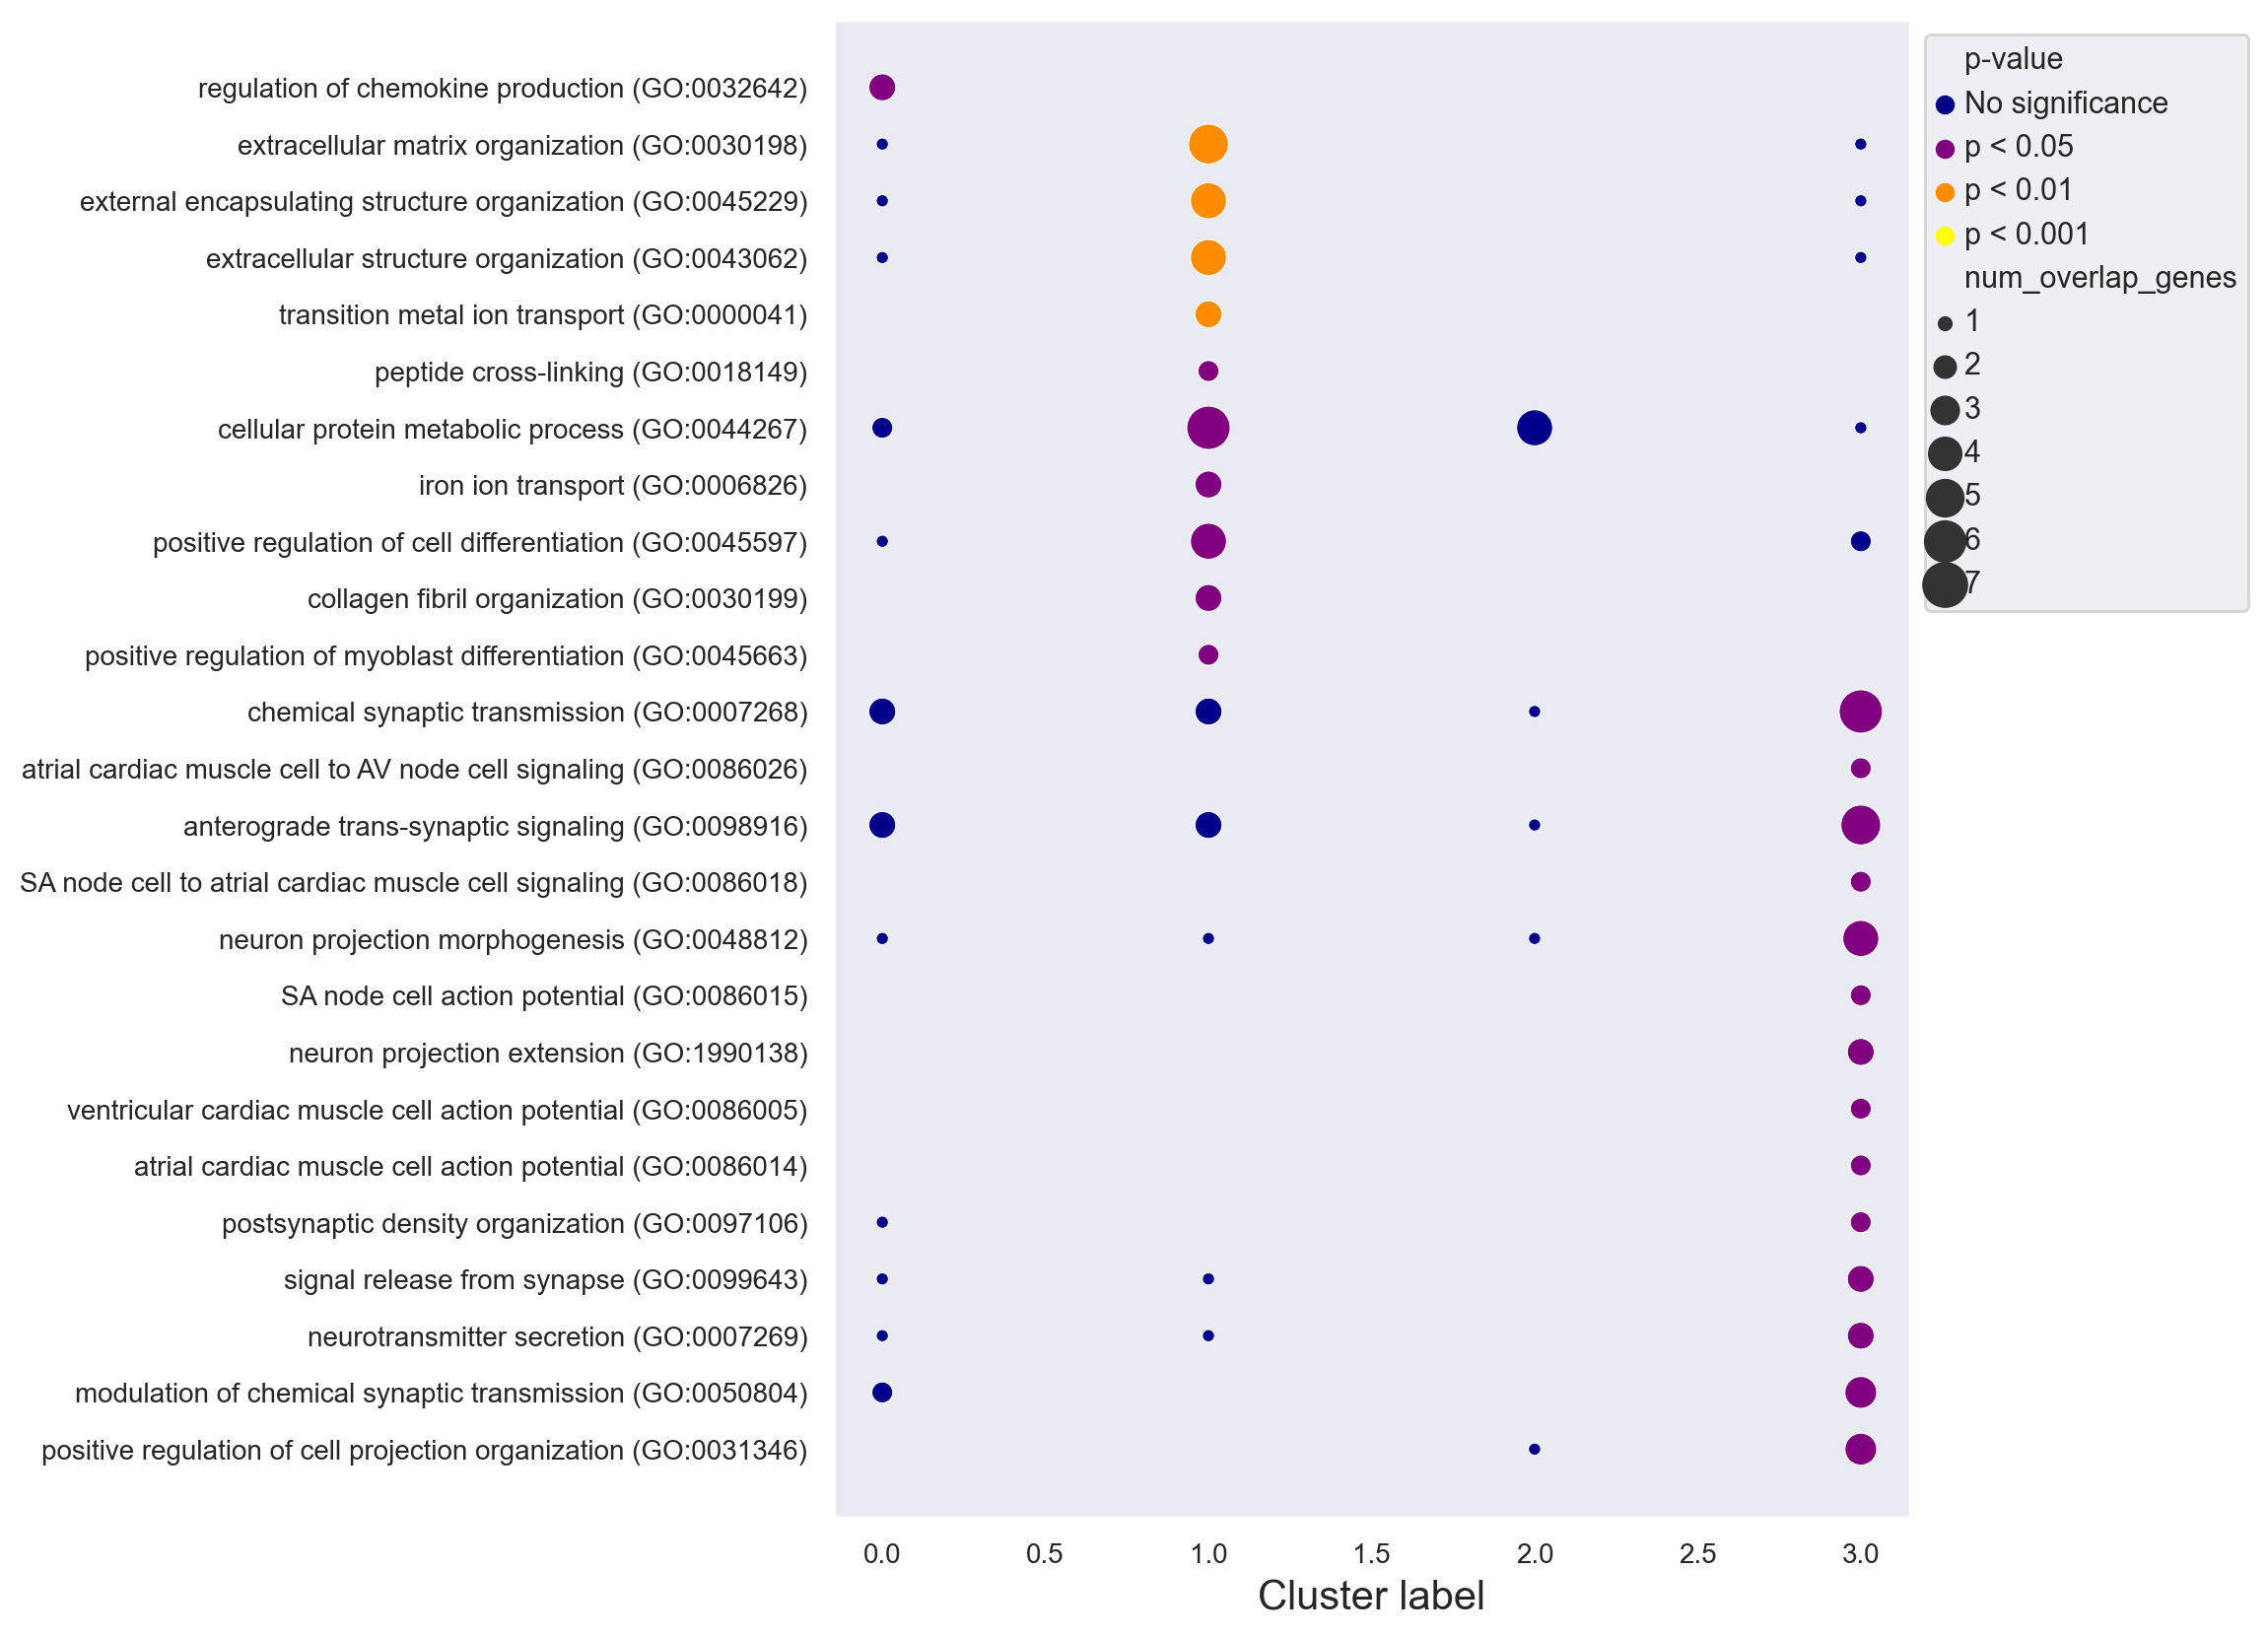

In [68]:
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [69]:
GeneCluster.enrich_geneclusters(gene_clust, 'Azimuth_Cell_Types_2021')

In [70]:
enrich_res = pd.concat([gc.enrichment_res['Azimuth_Cell_Types_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
SST+ DNAJC14+ Layer 5-6 GABAergic Neuron CL0000617     1  0.000080   
Schwann CL0002573                                      2  0.010399   
Erythroid Cell CL0000764                               3  0.015559   
Alpha Islet Cell CL0000171                             4  0.020692   
FEZF2+ RNF144A-AS1+ Layer 5 Glutamatergic Neuro...     5  0.020692   

                                                       Z-score  \
Term                                                             
SST+ DNAJC14+ Layer 5-6 GABAergic Neuron CL0000617  398.217391   
Schwann CL0002573                                   194.872340   
Erythroid Cell CL0000764                             97.425532   
Alpha Islet Cell CL0000171                           64.943262   
FEZF2+ RNF144A-AS1+ Layer 5 Glutamatergic Neuro...   64.943262   

                                                    Combined score  \
Term                                                                 
SST+ DNAJC14+ Layer 5-6 GABAergic Neuron CL0000617     3758.760314   
Schwann CL0002573                                       889.795971   
Erythroid Cell CL0000764                                405.595393   
Alpha Islet Cell CL0000171                              251.850038   
FEZF2+ RNF144A-AS1+ Layer 5 Glutamatergic Neuro...      251.850038   

                                                   Overlapping genes  \
Term                                                                   
SST+ DNAJC14+ Layer 5-6 GABAergic Neuron CL0000617   [PTPRK, LRRC4C]   
Schwann CL0002573                                             [PLP1]   
Erythroid Cell CL0000764                                     [TMCC2]   
Alpha Islet Cell CL0000171                                   [PCSK2]   
FEZF2+ RNF144A-AS1+ Layer 5 Glutamatergic Neuro...          [LRRC4C]   

                                                    Adjusted P-value  \
Term                                                                   
SST+ DNAJC14+ Layer 5-6 GABAergic Neuron CL0000617           0.00175   
Schwann CL0002573                                            0.04161   
Erythroid Cell CL0000764                                     0.04161   
Alpha Islet Cell CL0000171                                   0.04161   
FEZF2+ RNF144A-AS1+ Layer 5 Glutamatergic Neuro...           0.04161   

                                                    Old p-value  \
Term                                                              
SST+ DNAJC14+ Layer 5-6 GABAergic Neuron CL0000617            0   
Schwann CL0002573                                             0   
Erythroid Cell CL0000764                                      0   
Alpha Islet Cell CL0000171                                    0   
FEZF2+ RNF144A-AS1+ Layer 5 Glutamatergic Neuro...            0   

                                                    Old adjusted p-value  \
Term                                                                       
SST+ DNAJC14+ Layer 5-6 GABAergic Neuron CL0000617                     0   
Schwann CL0002573                                                      0   
Erythroid Cell CL0000764                                               0   
Alpha Islet Cell CL0000171                                             0   
FEZF2+ RNF144A-AS1+ Layer 5 Glutamatergic Neuro...                     0   

                                                    num_overlap_genes  \
Term                                                                    
SST+ DNAJC14+ Layer 5-6 GABAergic Neuron CL0000617                  2   
Schwann CL0002573                                                   1   
Erythroid Cell CL0000764                                            1   
Alpha Islet Cell CL0000171                                          1   
FEZF2+ RNF144A-AS1+ Layer 5 Glutamatergic Neuro...                  1   

                                                    neg_log10(p_adj)  \
Term      

In [71]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

35

In [72]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

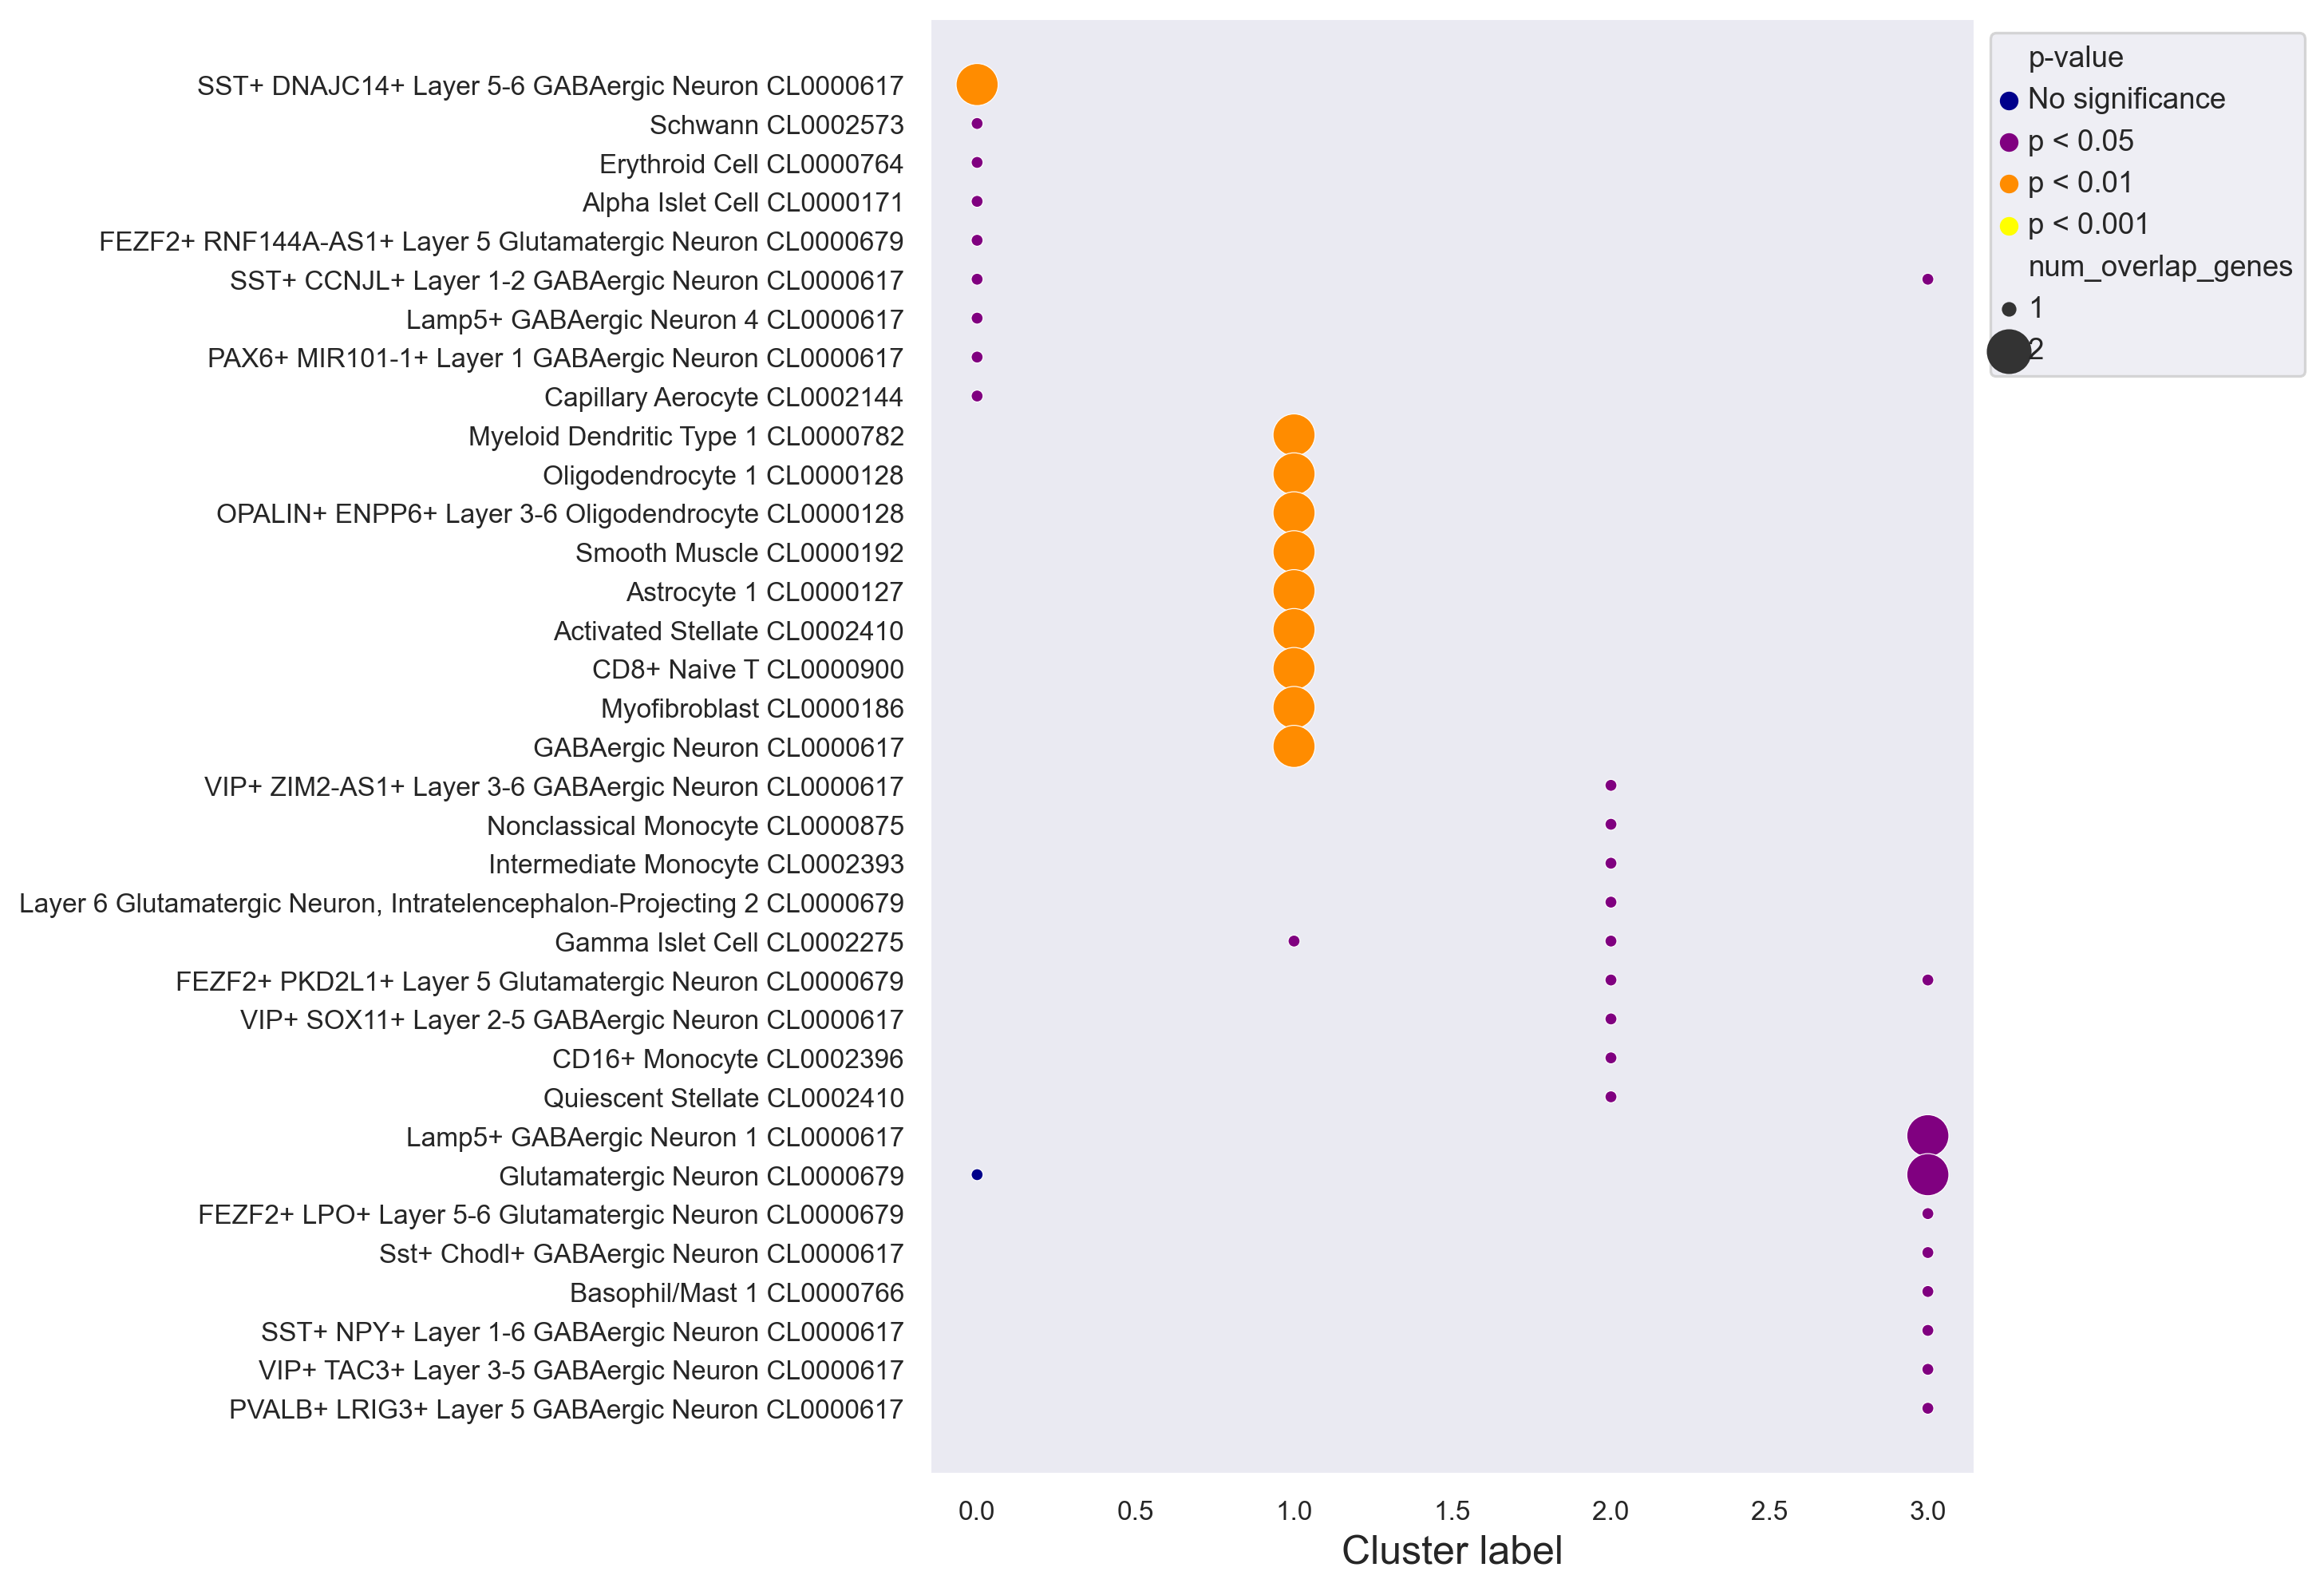

In [73]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [74]:
GeneCluster.enrich_geneclusters(gene_clust, 'MGI_Mammalian_Phenotype_Level_4_2021')

In [75]:
enrich_res = pd.concat([gc.enrichment_res['MGI_Mammalian_Phenotype_Level_4_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                            
decreased circulating glucagon level MP:0002696        1  0.000936  56.850932   
abnormal axon morphology MP:0005404                    2  0.001100   9.822511   
decreased circulating HDL cholesterol level MP:...     3  0.001520   8.960474   
decreased body weight MP:0001262                       4  0.002189   3.167389   
abnormal locomotor behavior MP:0001392                 5  0.002422   7.839827   

                                                    Combined score  \
Term                                                                 
decreased circulating glucagon level MP:0002696         396.480493   
abnormal axon morphology MP:0005404                      66.917908   
decreased circulating HDL cholesterol level MP:...       58.146989   
decreased body weight MP:0001262                         19.398477   
abnormal locomotor behavior MP:0001392                   47.219840   

                                                                                    Overlapping genes  \
Term                                                                                                    
decreased circulating glucagon level MP:0002696                                        [PCSK2, PCSK1]   
abnormal axon morphology MP:0005404                                       [ZBTB18, PLP1, NR2F1, NEFL]   
decreased circulating HDL cholesterol level MP:...                         [NRXN1, ELMOD1, CHN1, LPL]   
decreased body weight MP:0001262                    [PCSK1, GNAZ, APP, RIMS4, NRN1, TNKS2, ZMYND8,...   
abnormal locomotor behavior MP:0001392                                     [PCSK2, APP, ELMOD1, CHN1]   

                                                    Adjusted P-value  \
Term                                                                   
decreased circulating glucagon level MP:0002696             0.161104   
abnormal axon morphology MP:0005404                         0.161104   
decreased circulating HDL cholesterol level MP:...          0.161104   
decreased body weight MP:0001262                            0.161104   
abnormal locomotor behavior MP:0001392                      0.161104   

                                                    Old p-value  \
Term                                                              
decreased circulating glucagon level MP:0002696               0   
abnormal axon morphology MP:0005404                           0   
decreased circulating HDL cholesterol level MP:...            0   
decreased body weight MP:0001262                              0   
abnormal locomotor behavior MP:0001392                        0   

                                                    Old adjusted p-value  \
Term                                                                       
decreased circulating glucagon level MP:0002696                        0   
abnormal axon morphology MP:0005404                                    0   
decreased circulating HDL cholesterol level MP:...                     0   
decreased body weight MP:0001262                                       0   
abnormal locomotor behavior MP:0001392                                 0   

                                                    num_overlap_genes  \
Term                                                                    
decreased circulating glucagon level MP:0002696                     2   
abnormal axon morphology MP:0005404                                 4   
decreased circulating HDL cholesterol level MP:...                  4   
decreased body weight MP:0001262                                   11   
abnormal locomotor behavior MP:0001392                              4   

                                                    neg_log10(p_adj)  \
Term                                                                   
decreased circulating glucagon level MP:0002696             0.792893   
abnormal axon morphol

In [76]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

21

In [77]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

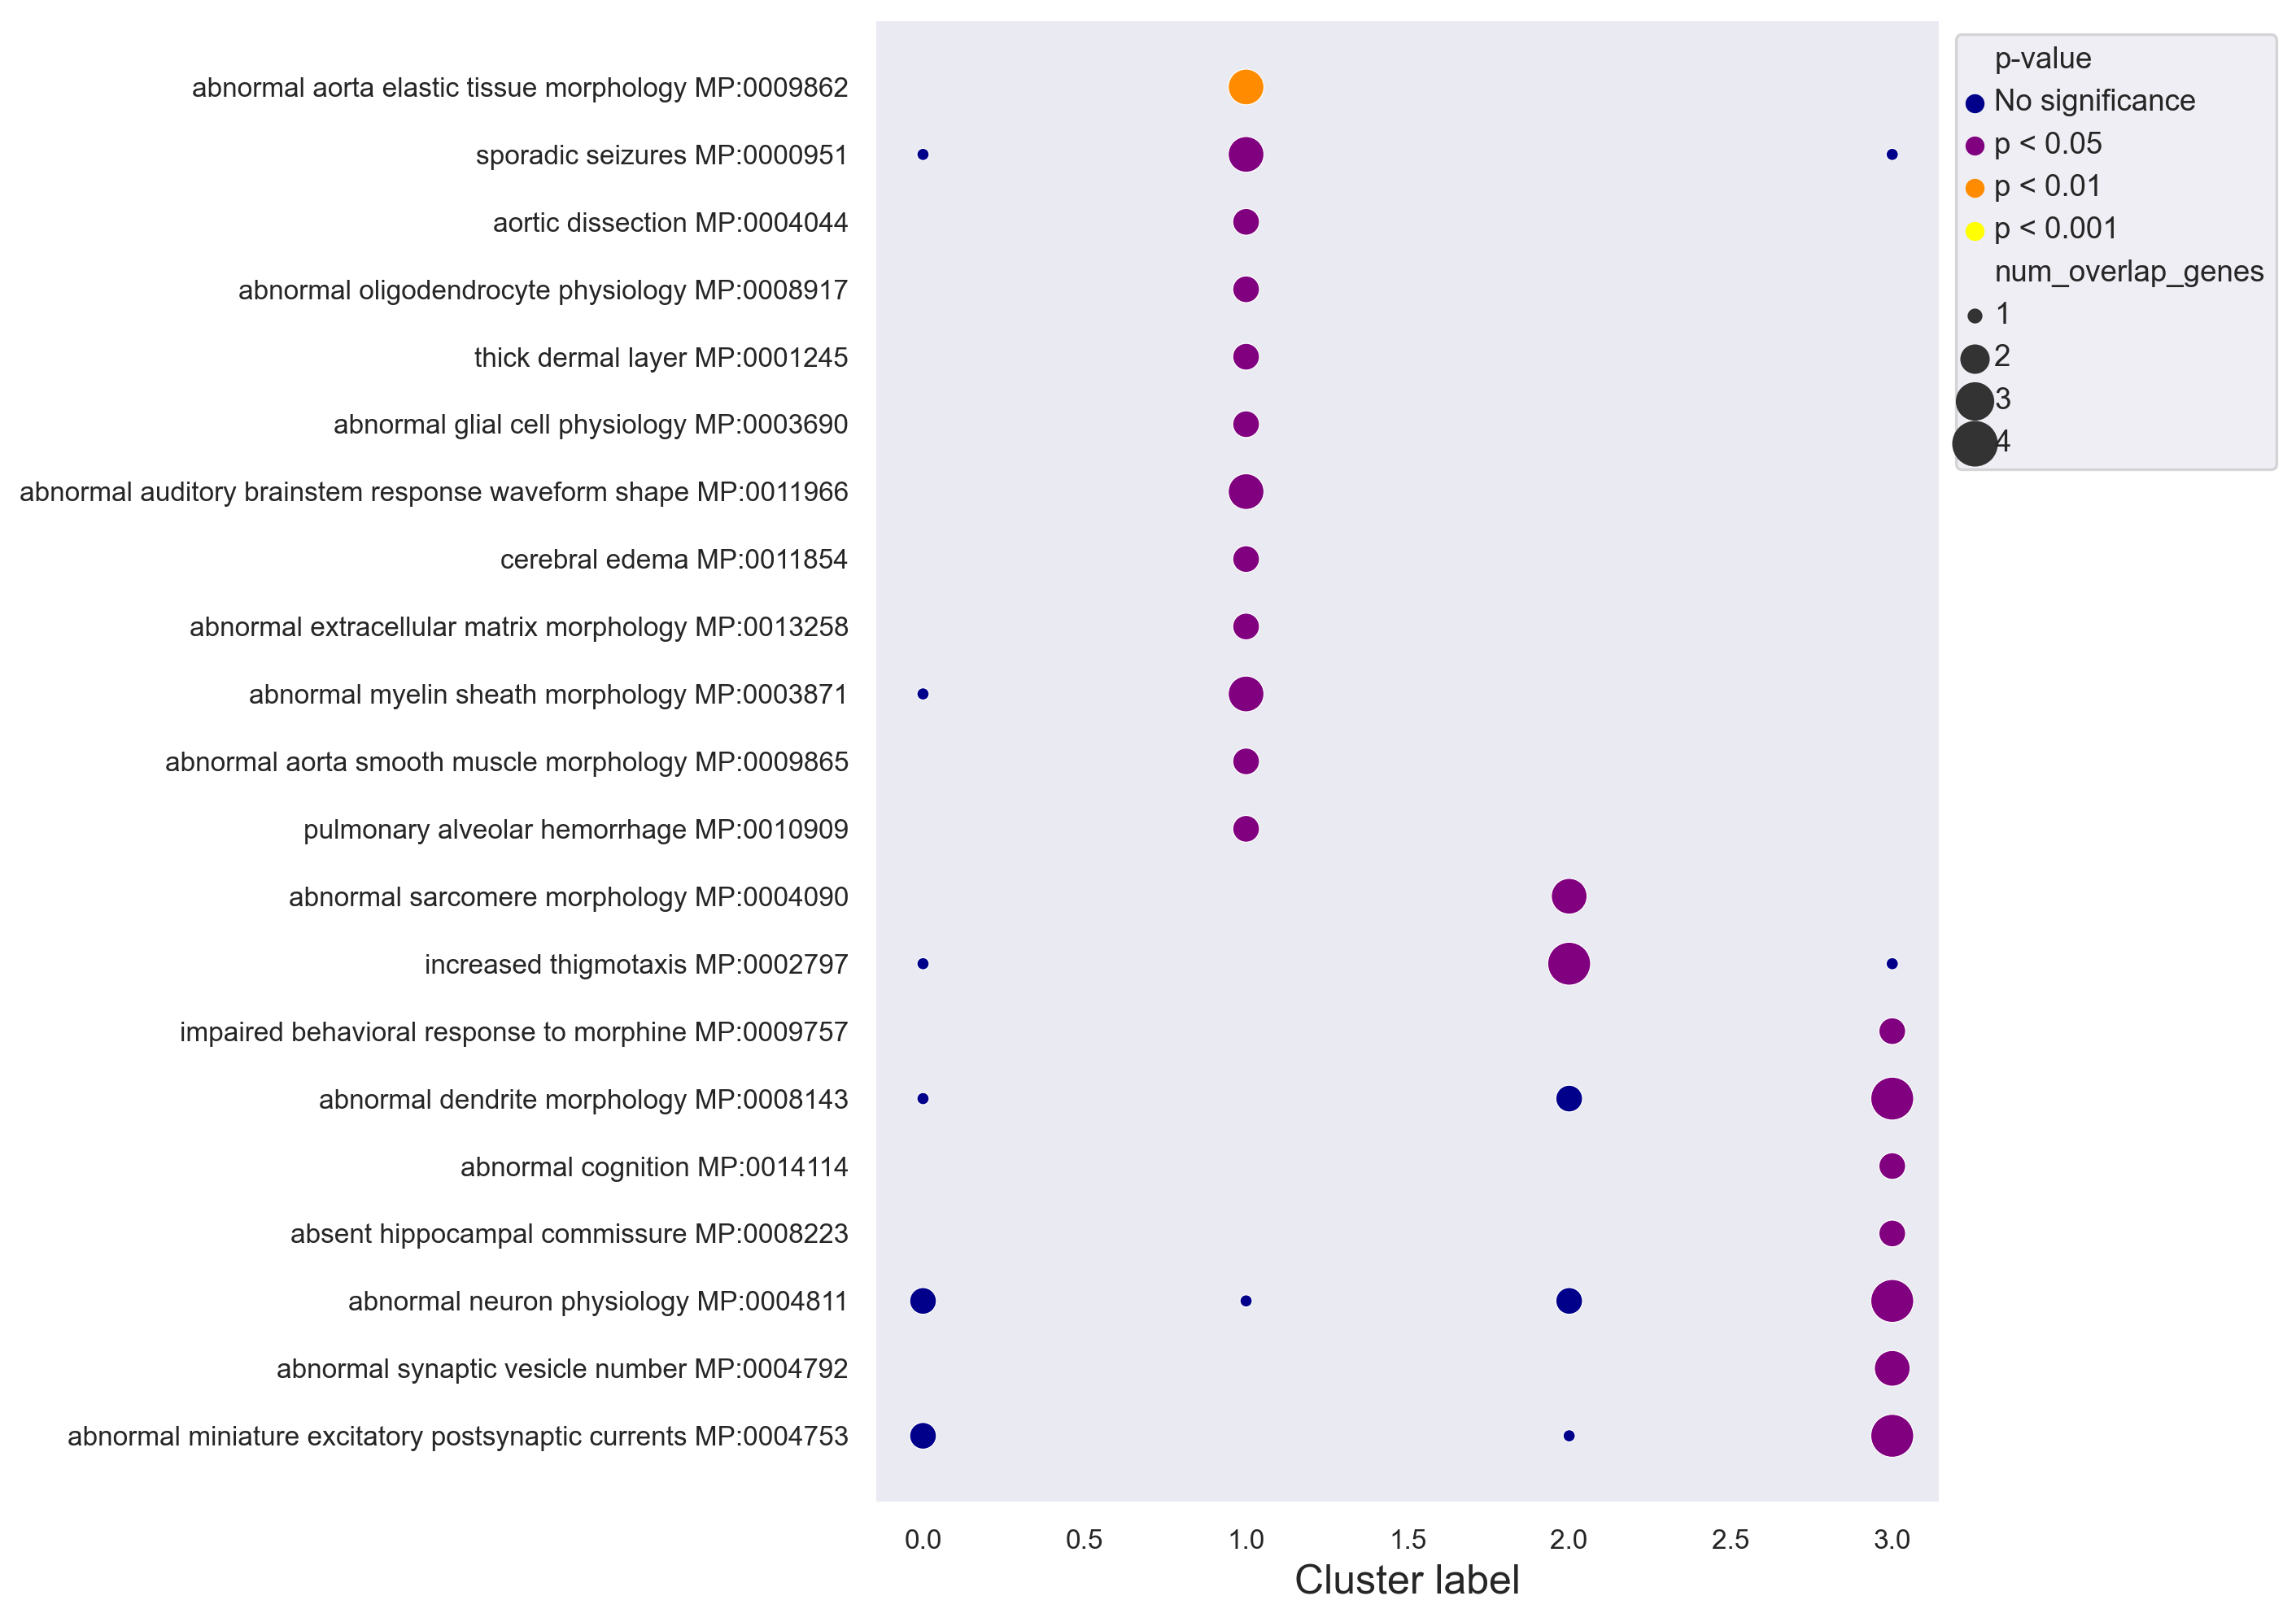

In [78]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [79]:
GeneCluster.enrich_geneclusters(gene_clust, 'Reactome_2022')

In [80]:
enrich_res = pd.concat([gc.enrichment_res['Reactome_2022'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
Insulin Processing R-HSA-264876                        1  0.005246   
Developmental Biology R-HSA-1266738                    2  0.007756   
Formyl Peptide Receptors Bind Formyl Peptides A...     3  0.010399   
Chylomicron Remodeling R-HSA-8963901                   4  0.010399   
Expression And Translocation Of Olfactory Recep...     5  0.010399   

                                                       Z-score  \
Term                                                             
Insulin Processing R-HSA-264876                      20.917620   
Developmental Biology R-HSA-1266738                   3.118841   
Formyl Peptide Receptors Bind Formyl Peptides A...  194.872340   
Chylomicron Remodeling R-HSA-8963901                194.872340   
Expression And Translocation Of Olfactory Recep...  194.872340   

                                                    Combined score  \
Term                                                                 
Insulin Processing R-HSA-264876                         109.823974   
Developmental Biology R-HSA-1266738                      15.155256   
Formyl Peptide Receptors Bind Formyl Peptides A...      889.795971   
Chylomicron Remodeling R-HSA-8963901                    889.795971   
Expression And Translocation Of Olfactory Recep...      889.795971   

                                                                                    Overlapping genes  \
Term                                                                                                    
Insulin Processing R-HSA-264876                                                        [PCSK2, PCSK1]   
Developmental Biology R-HSA-1266738                 [DOK5, DPYSL5, LHX2, AKT3, LPL, PABPC1, NEO1, ...   
Formyl Peptide Receptors Bind Formyl Peptides A...                                              [APP]   
Chylomicron Remodeling R-HSA-8963901                                                            [LPL]   
Expression And Translocation Of Olfactory Recep...                                             [LHX2]   

                                                    Adjusted P-value  \
Term                                                                   
Insulin Processing R-HSA-264876                             0.310457   
Developmental Biology R-HSA-1266738                         0.310457   
Formyl Peptide Receptors Bind Formyl Peptides A...          0.310457   
Chylomicron Remodeling R-HSA-8963901                        0.310457   
Expression And Translocation Of Olfactory Recep...          0.310457   

                                                    Old p-value  \
Term                                                              
Insulin Processing R-HSA-264876                               0   
Developmental Biology R-HSA-1266738                           0   
Formyl Peptide Receptors Bind Formyl Peptides A...            0   
Chylomicron Remodeling R-HSA-8963901                          0   
Expression And Translocation Of Olfactory Recep...            0   

                                                    Old adjusted p-value  \
Term                                                                       
Insulin Processing R-HSA-264876                                        0   
Developmental Biology R-HSA-1266738                                    0   
Formyl Peptide Receptors Bind Formyl Peptides A...                     0   
Chylomicron Remodeling R-HSA-8963901                                   0   
Expression And Translocation Of Olfactory Recep...                     0   

                                                    num_overlap_genes  \
Term                                                                    
Insulin Processing R-HSA-264876                                     2   
Developmental Biology R-HSA-1266738                                 8   
Formyl Peptide Receptors Bind Formyl Peptides A...                  1  

In [81]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

29

In [82]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

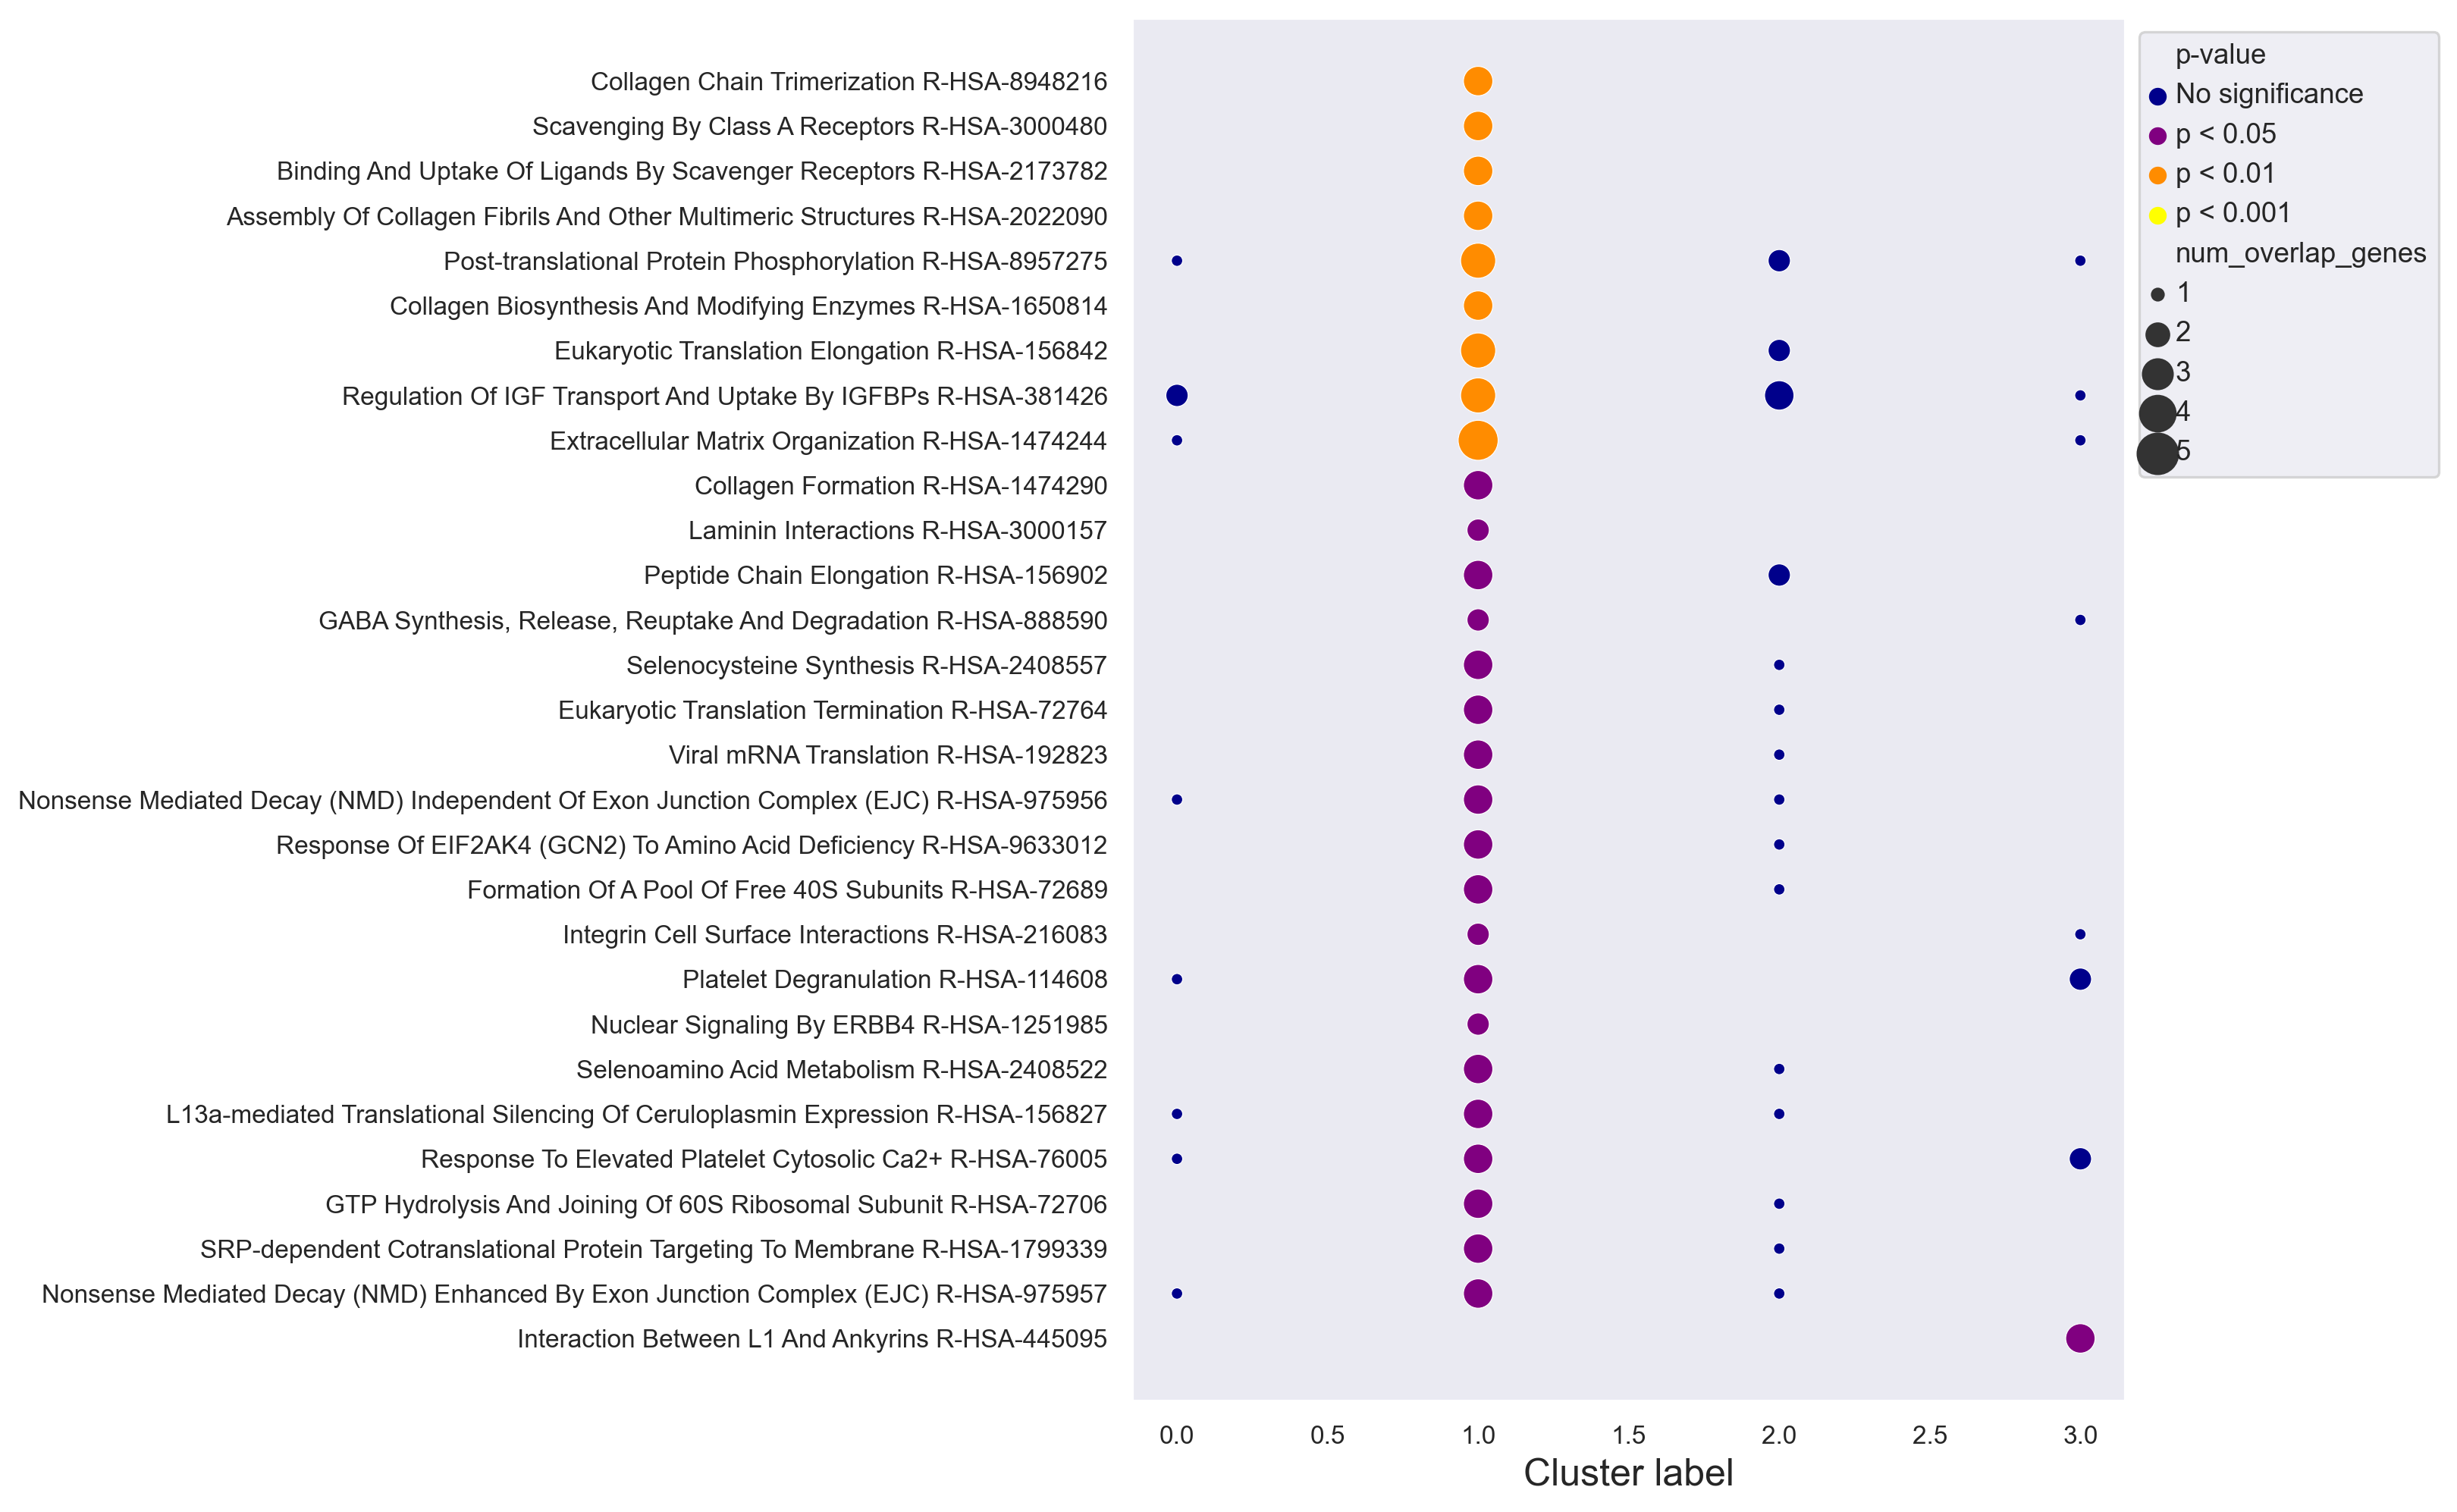

In [83]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [84]:
GeneCluster.enrich_geneclusters(gene_clust, 'KEGG_2021_Human')

In [85]:
enrich_res = pd.concat([gc.enrichment_res['KEGG_2021_Human'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                               
Cell adhesion molecules                   1  0.003355  11.036364   
Cholesterol metabolism                    2  0.006278  18.921325   
Carbohydrate digestion and absorption     3  0.006826  18.059289   
cGMP-PKG signaling pathway                4  0.012428   6.718519   
PPAR signaling pathway                    5  0.014191  12.025033   

                                       Combined score  \
Term                                                    
Cell adhesion molecules                     62.876717   
Cholesterol metabolism                      95.943521   
Carbohydrate digestion and absorption       90.060888   
cGMP-PKG signaling pathway                  29.479631   
PPAR signaling pathway                      51.168408   

                                             Overlapping genes  \
Term                                                             
Cell adhesion molecules                  [NRXN1, LRRC4C, NEO1]   
Cholesterol metabolism                             [LPL, TSPO]   
Carbohydrate digestion and absorption           [AKT3, ATP1A1]   
cGMP-PKG signaling pathway             [GUCY1B1, AKT3, ATP1A1]   
PPAR signaling pathway                            [FABP7, LPL]   

                                       Adjusted P-value  Old p-value  \
Term                                                                   
Cell adhesion molecules                        0.298087            0   
Cholesterol metabolism                         0.298087            0   
Carbohydrate digestion and absorption          0.298087            0   
cGMP-PKG signaling pathway                     0.344525            0   
PPAR signaling pathway                         0.344525            0   

                                       Old adjusted p-value  \
Term                                                          
Cell adhesion molecules                                   0   
Cholesterol metabolism                                    0   
Carbohydrate digestion and absorption                     0   
cGMP-PKG signaling pathway                                0   
PPAR signaling pathway                                    0   

                                       num_overlap_genes  neg_log10(p_adj)  \
Term                                                                         
Cell adhesion molecules                                3          0.525658   
Cholesterol metabolism                                 2          0.525658   
Carbohydrate digestion and absorption                  2          0.525658   
cGMP-PKG signaling pathway                             3          0.462779   
PPAR signaling pathway                                 2          0.462779   

                                       cluster_label  
Term                                                  
Cell adhesion molecules                            0  
Cholesterol metabolism                             0  
Carbohydrate digestion and absorption              0  
cGMP-PKG signaling pathway                         0  
PPAR signaling pathway                             0

In [86]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

2

In [87]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

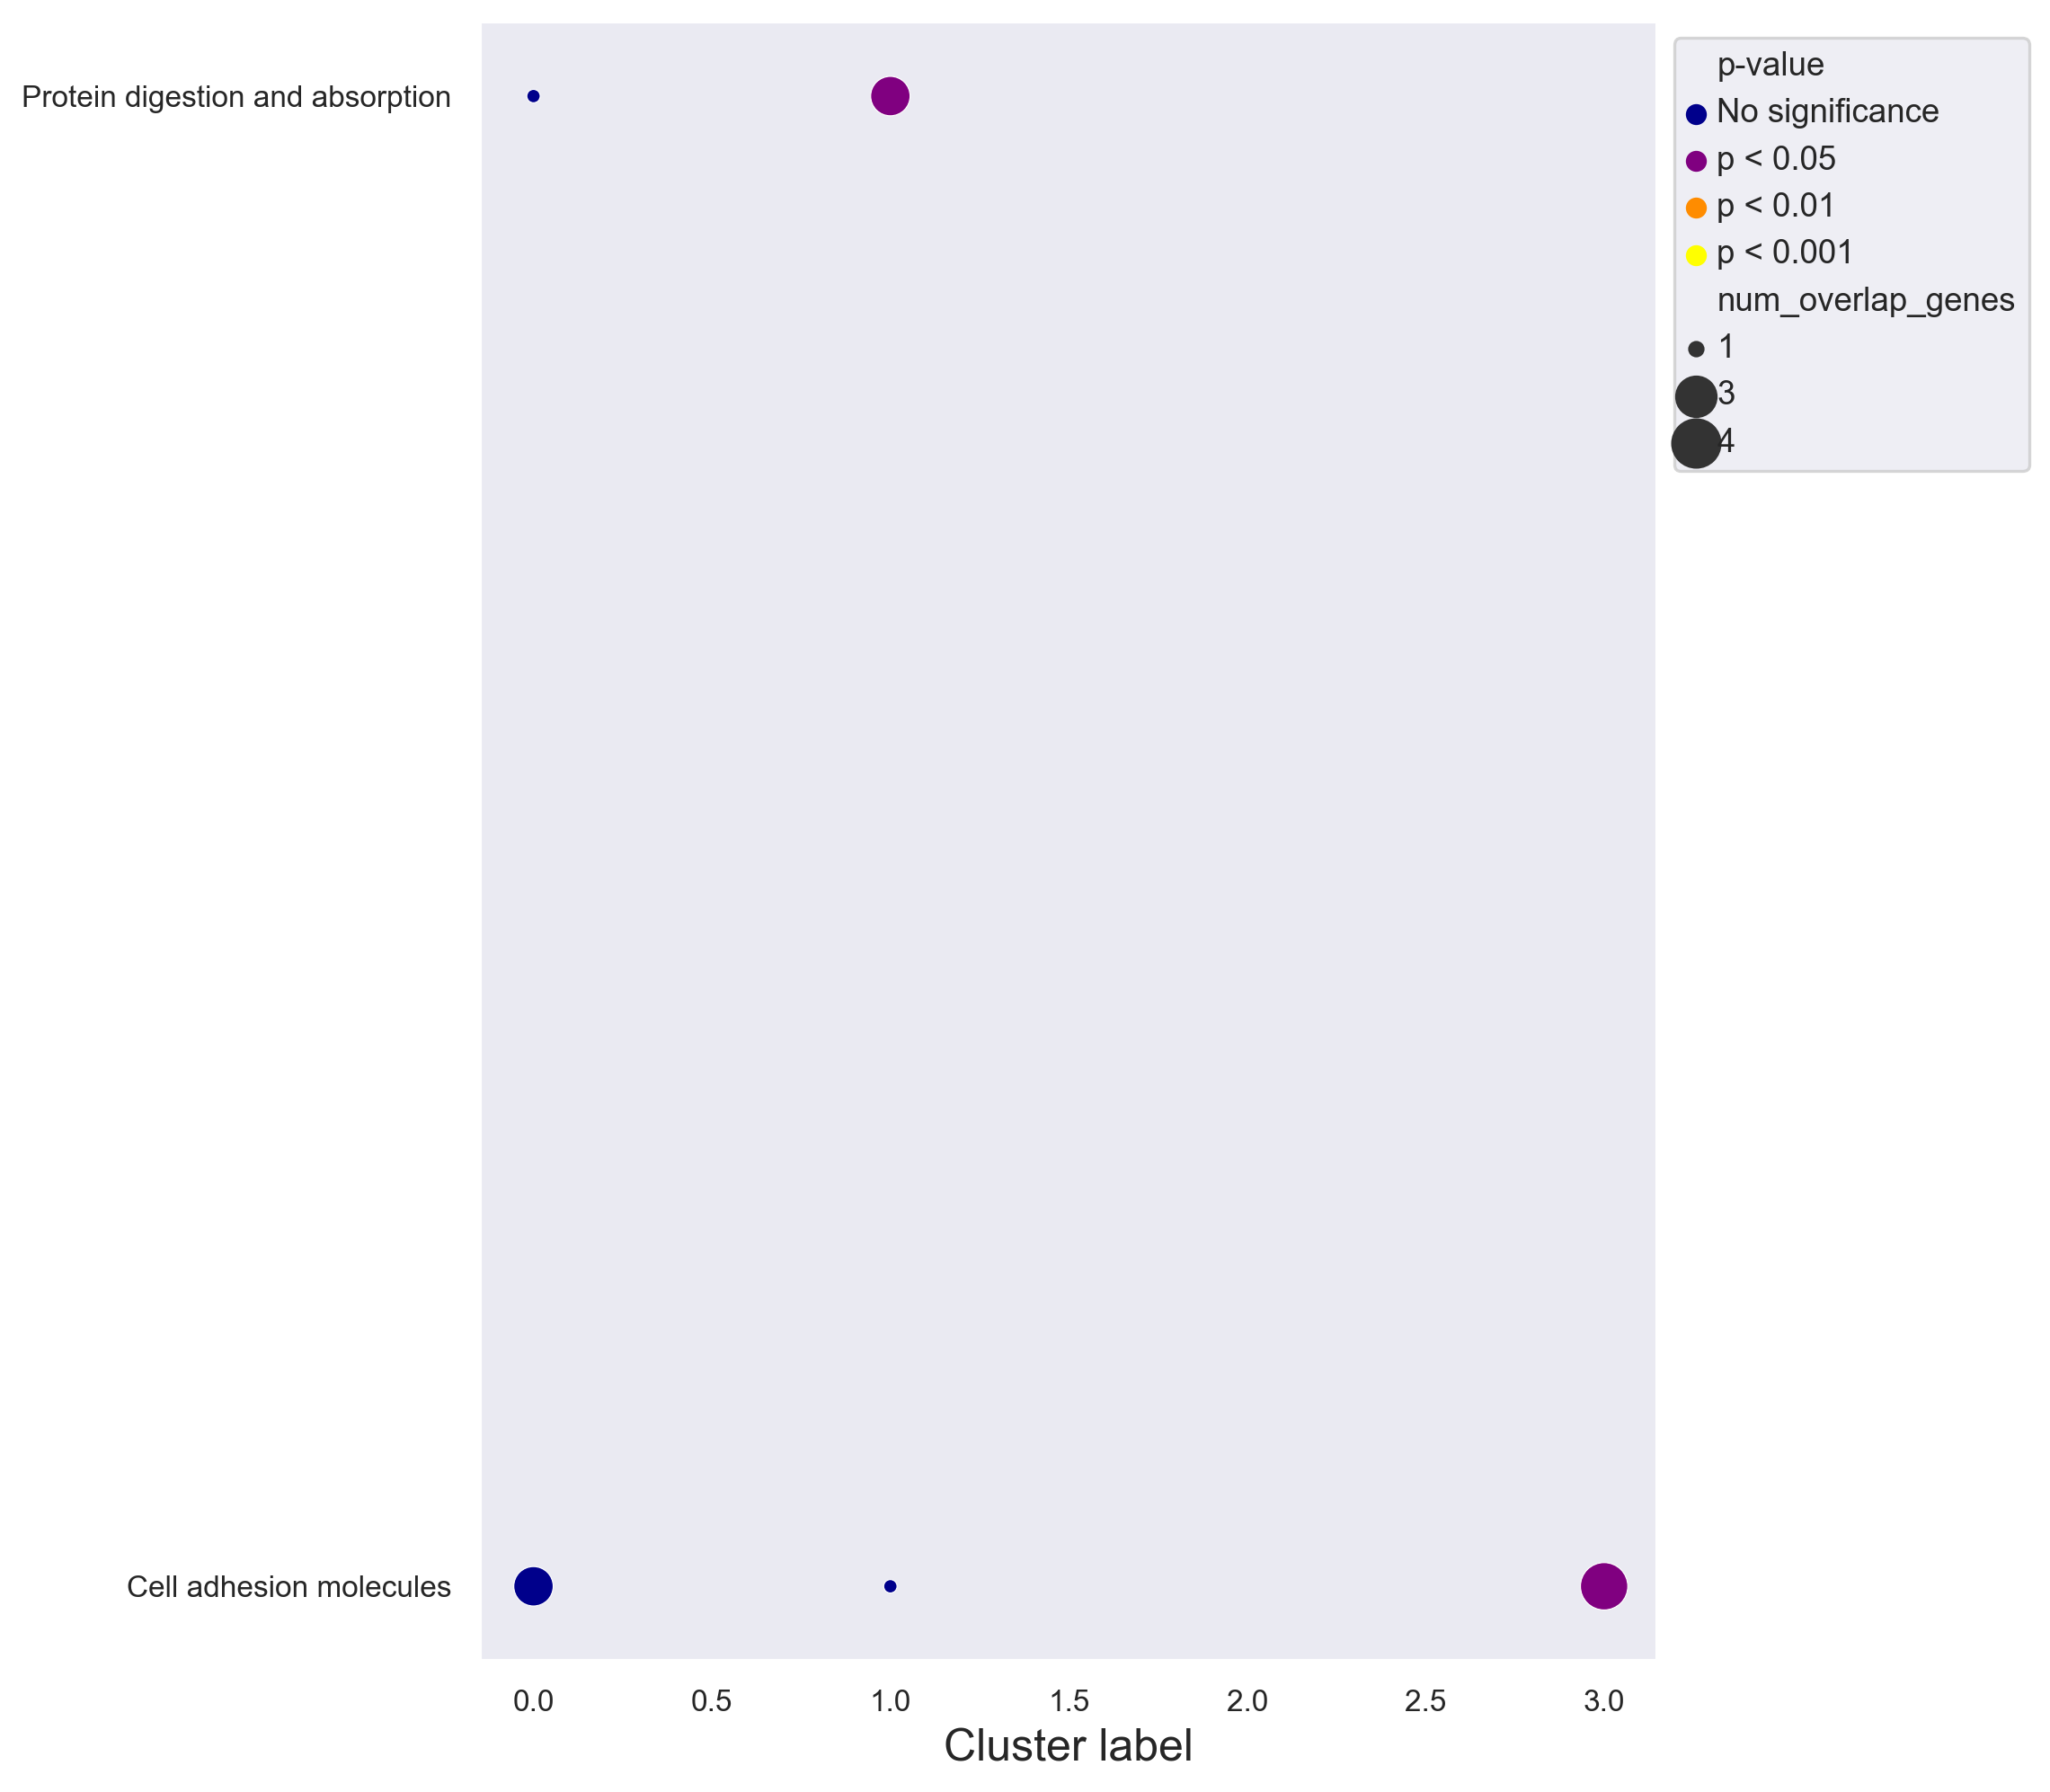

In [88]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))